<h1><center>Wine Quality Dataset Analyzing and Predictions</center></h1>

<h2 align = "center"><a href = "https://github.com/joshjanda1">Josh Janda</a></h2>

<h2>Introduction</h2>

The dataset being used in this project is downloaded freom the UCI Machine Learning Repository. The dataset is related to red and white variants of the Portuguese "Vinho Verde" wine. The target variable for this dataset is going to be the wine quality of each individual wine, on a scale of 1-10. There are 11 features associated with the wine quality output variable, although the exact importance of each variable is unknown and will be therefore analyzed. The 11 variables are:

- Fixed Acidity
- Volatile Acidity
- Citric Acid
- Residual Sugar
- Chlorides
- Free sulfur Dioxide
- Total Sulfure Dioxide
- Density
- pH
- Sulphates
- Alcohol Content
- Color Label (White or Red, used to distinguish between each wine type)

The target variable is:

- Quality of Wine (scale of 1-10).

I will be treating this problem of predicting wine quality as a regression task rather than a classification task. I will be modeling the data using a base multivariate linear regression model, and a ridge regression model. Each model will be tuned utilizing cross-validation, and the best model will be used for analyzing performance on held out test data. Each model will be built from scratch, and math will be explained.

Ultimately, the goal of the project is to create an efficient linear regression algorithm utilizing stochastic graident descent that can perform well on predicting wine qualities.

<h2>Loading and Analyzing Data</h2>

Before jumping into feeding the data into a modeling algorithm for prediction, it's best to analyze and understand the data we are working with beforehand. I will be doing just that.

In [160]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import itertools
#end imports

wine_data_white = pd.read_csv("winequality-white.csv", delimiter = ";")
wine_data_red = pd.read_csv("winequality-red.csv", delimiter = ";")

wine_data_white["color_label"] = "white"
wine_data_red["color_label"] = "red"
wine_data = pd.concat((wine_data_white, wine_data_red), axis = 0)

wine_data.head() # look at first few observations of each variable

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color_label
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


We can see the first few observations of each variable above. Right away it obvious that some scaling of variables may be warranted due to the difference of number ranges in each variable, which can ultimately effect the model negatively by prioritizing more extreme values.

In [2]:
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


The table above confirms our statement regarding the ranges of each variable, as we can see each variable has pretty sizeable differences in means and standard deviations. The variables will be scaled later on to have a mean of zero and a standard deviation of one. 

I will now be checking for missing values in the dataset.

In [3]:
wine_data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color_label             0
dtype: int64

Conveniently, there are no missing values in this dataset so imputation/data removal will not be needed.

Up next will be analyzing/viewing correlation/linear relationships between the variables, as well as checking for extreme multicollinearity problems.

In [4]:
wine_data.corr().style.apply(lambda x: ['background-color : yellow' if v > .80 else "" for v in x], axis = 1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.45891,-0.2527,0.299568,-0.0954515,-0.0767432
volatile acidity,0.219008,1,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.0376404,-0.265699
citric acid,0.324436,-0.377981,1,0.142451,0.038998,0.133126,0.195242,0.0961539,-0.329808,0.0561973,-0.0104935,0.0855317
residual sugar,-0.111981,-0.196011,0.142451,1,-0.12894,0.402871,0.495482,0.552517,-0.26732,-0.185927,-0.359415,-0.0369805
chlorides,0.298195,0.377124,0.038998,-0.12894,1,-0.195045,-0.27963,0.362615,0.044708,0.395593,-0.256916,-0.200666
free sulfur dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1,0.720934,0.0257168,-0.145854,-0.188457,-0.179838,0.0554631
total sulfur dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.27963,0.720934,1,0.0323945,-0.238413,-0.275727,-0.26574,-0.0413855
density,0.45891,0.271296,0.0961539,0.552517,0.362615,0.0257168,0.0323945,1,0.0116861,0.259478,-0.686745,-0.305858
pH,-0.2527,0.261454,-0.329808,-0.26732,0.044708,-0.145854,-0.238413,0.0116861,1,0.192123,0.121248,0.0195057
sulphates,0.299568,0.225984,0.0561973,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1,-0.00302919,0.0384854


Above is a correlation matrix of the dataset.

I have defined an extreme case of multicollinearity to be if the correlation between two variables is greater than .80, and any observation above is highlighted in yellow if the correlation is above that value of .80.

Since the diagonals are all equal to `1` as they are the correlation between each variable and itself, all diaganols are highlighted in yellow. Other than the diagonals, there are no actual cases of extreme multicollinearity.

Since there are two different colors of wine being analyzed, I believe that a scatter matrix may also warrant some useful information to see if data deviates greatly between each color.

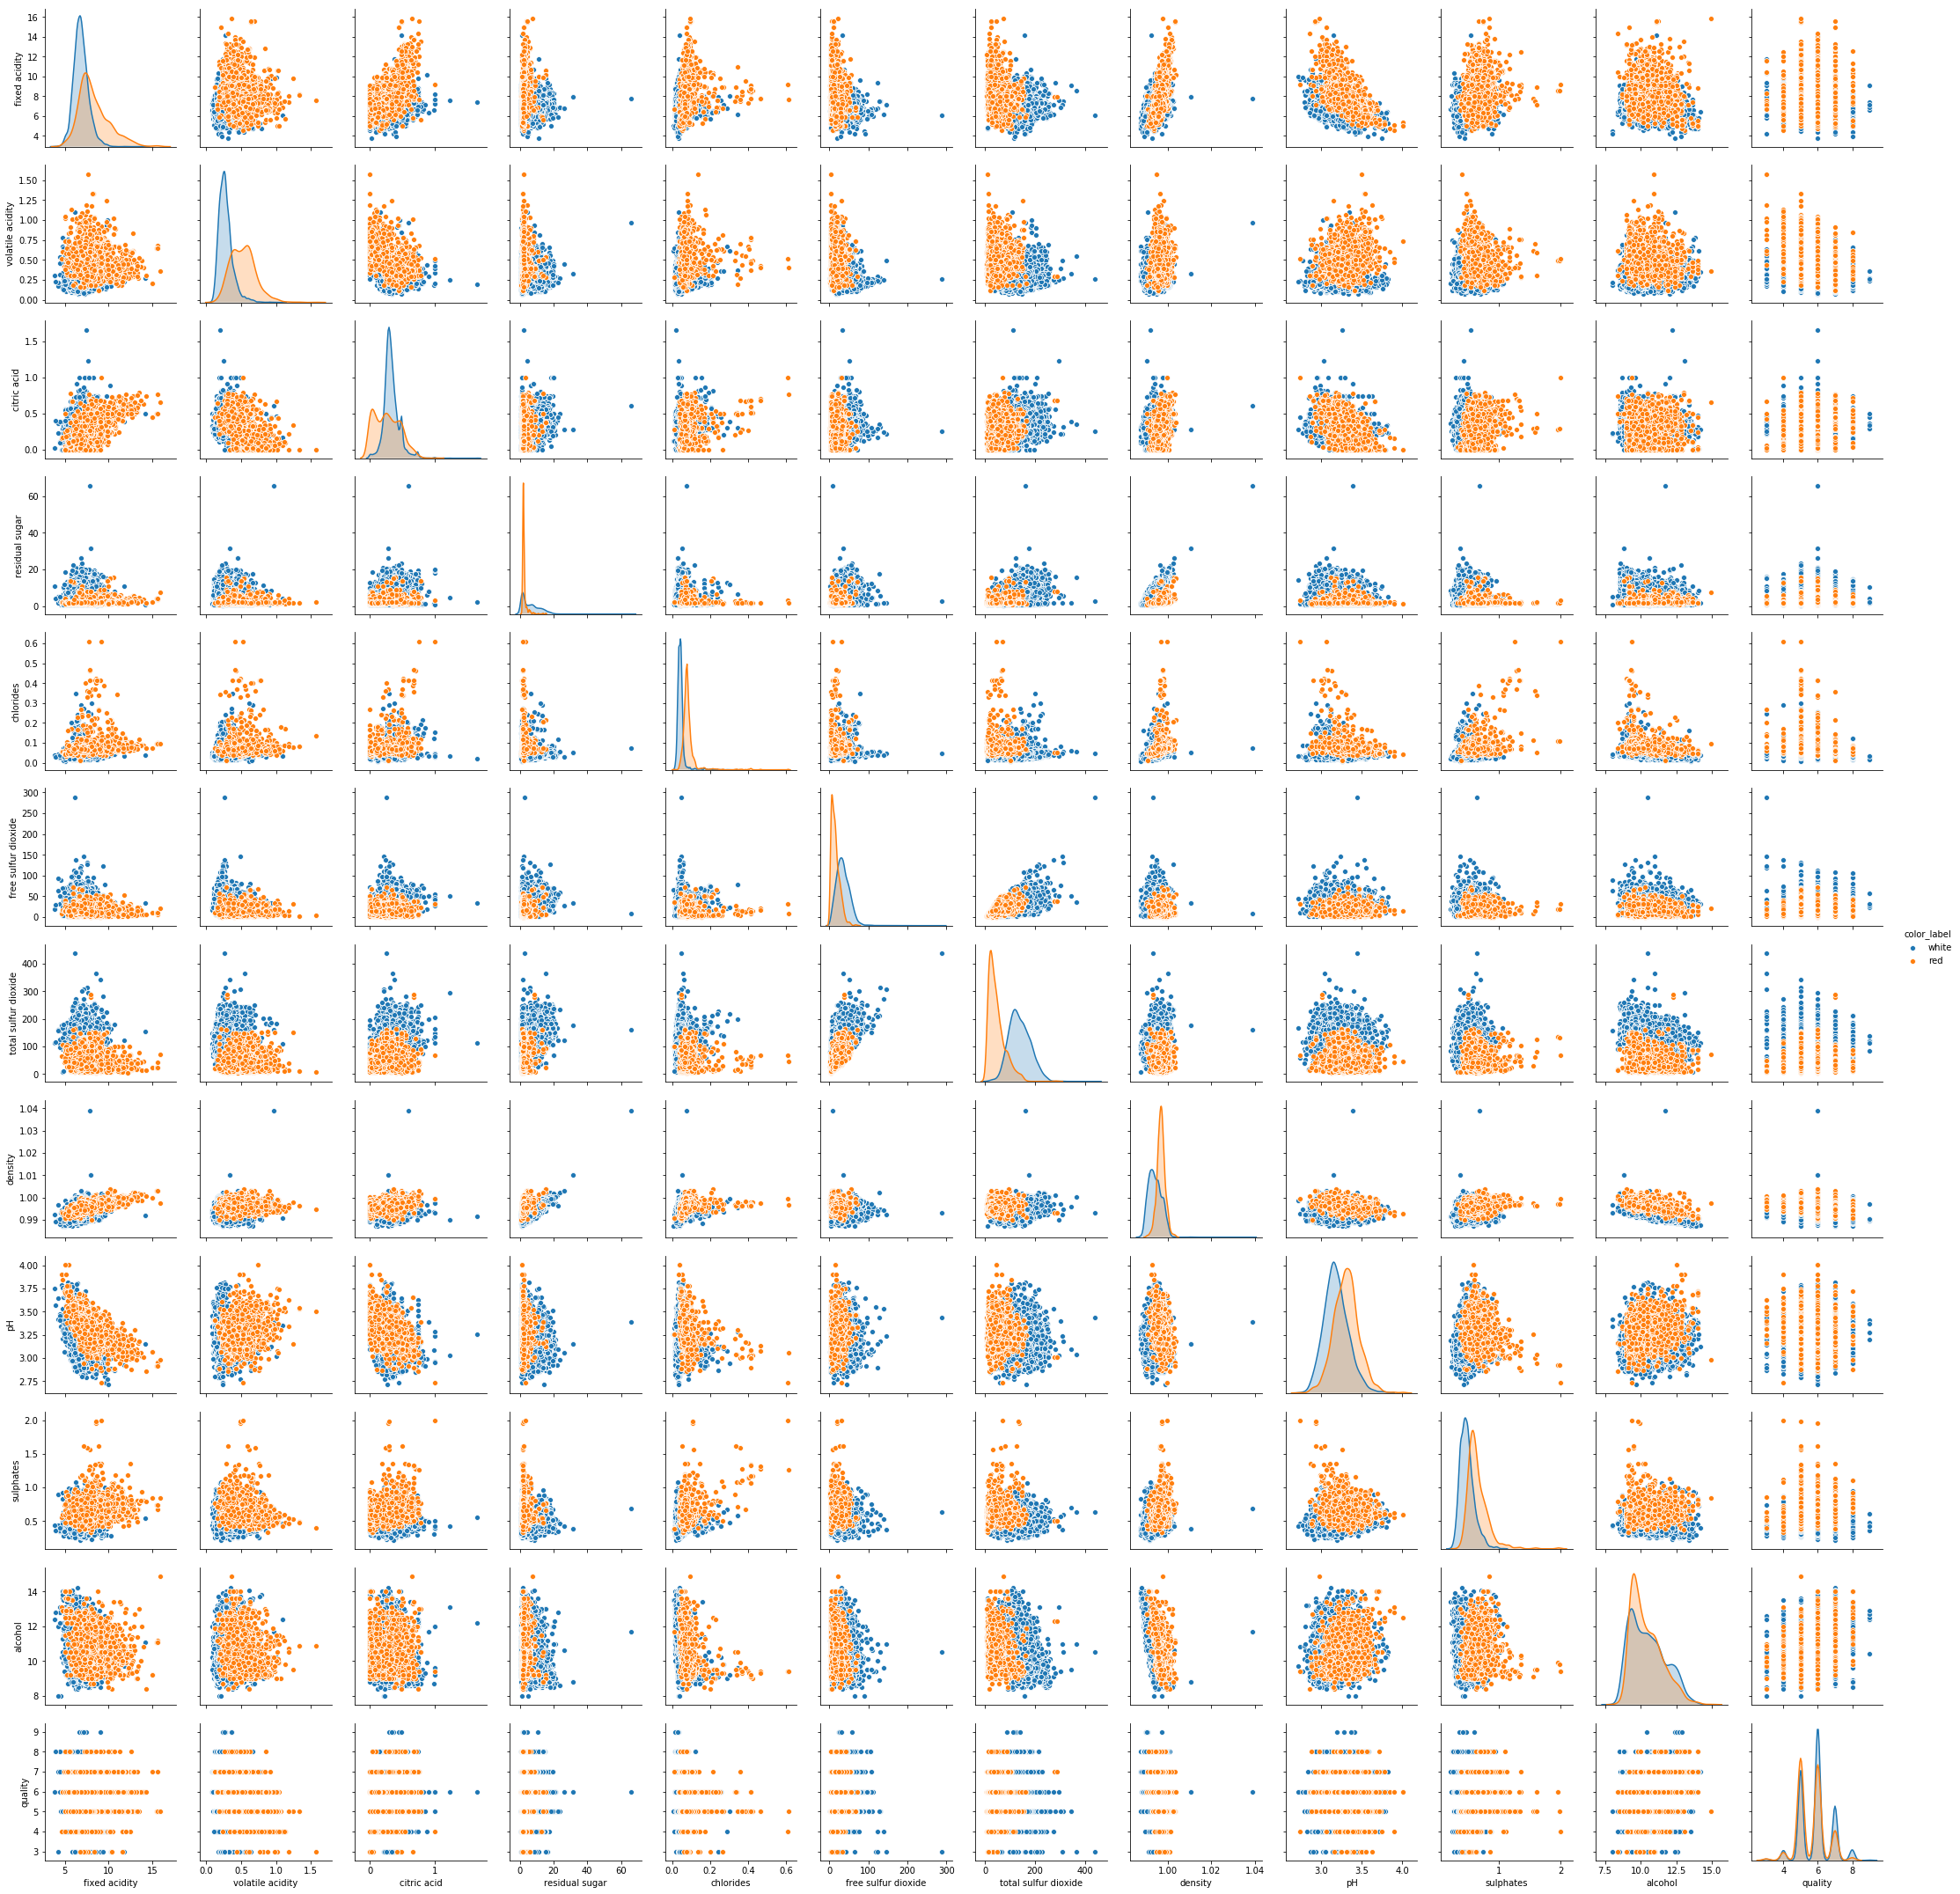

In [5]:
sns.pairplot(wine_data, hue = "color_label")

Looking at the figure above, the data looks very similar between both the white and red wine for each variable. This tells me that the data does not deviate greatly between wine color, and will not hinder the predictions by much if at all. 

Overall, the null value checks, and correlation / scatter matrix analyzing leads me to believe that the only variable alteration needed to be done is scaling which will be performed during model fitting.

Lastly, although the deviance between the data between wine colors is very small I will be checking the count of each wine color and quality.

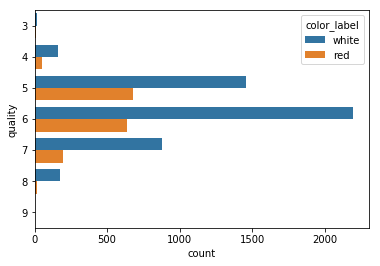

In [6]:
sns.countplot(y = "quality", hue = "color_label",
             data = wine_data)

Looking at the barplot above, we can see that a quality of `5` and `6` are the most frequent between both the white and red wines. Color wise, the frequencies are very similar between each color which further justifies the data does not deviate much between each color.

Analyzing the data is now complete. I will be moving forwasrd to splitting the data into a training and validation set, and then building the models to predict.

<h2>Splitting Data</h2>

In order to train and then test our model to measure performance on unseen data, I will be splitting the data into a training and testing set. I will be utilizing stratified splitting in order to keep the ratio of qualities in each of the datasets to a mostly equal amount within some error.

First, let's convert the `color_label` variable to a dummy variable that takes on `1` if the color is `red` and `0` if the color is `white`.

In [7]:
wine_data_encoded = wine_data.copy()
wine_data_encoded = pd.get_dummies(wine_data_encoded,
                                   columns = ["color_label"]).drop("color_label_white",
                                                                   axis = 1).rename(columns =
                                                                                    {"color_label_red": "color_dummy"})
wine_data_encoded.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color_dummy
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0


With our final dataset created with an included dummy variable for wine color, I will now split the data as mentioned above.

In [8]:
X = wine_data_encoded.drop("quality", axis = 1).to_numpy() # convert X to a numpy array for easier use
y = wine_data_encoded["quality"].to_numpy().reshape(X.shape[0], 1) # convert y to a numpy array for easier use

skf = StratifiedKFold(n_splits = 5,
                     random_state = 490)

for trn_idx, tst_idx in skf.split(X, y):
    
    Xtrain, Xtest = X[trn_idx], X[tst_idx]
    ytrain, ytest = y[trn_idx], y[tst_idx]
    
train_ratios = []
test_ratios = []

for i in range(1, 11):
    train_ratios.append(len(ytrain[ytrain == i]) / len(ytrain))
    test_ratios.append(len(ytest[ytest == i]) / len(ytest))

ratio_comparison_df = pd.DataFrame(data = np.column_stack((np.arange(1, 11), train_ratios, test_ratios)),
                                  index = np.arange(1, 11),
                                  columns = ["Quality", "Train Ratio", "Test Ratio"])
ratio_comparison_df.round(4).style.hide_index()

Quality,Train Ratio,Test Ratio
1,0,0
2,0,0
3,0.0046,0.0046
4,0.0333,0.0332
5,0.329,0.3292
6,0.4363,0.4372
7,0.1662,0.1658
8,0.0298,0.0293
9,0.0008,0.0008
10,0,0


Looking at the table above, our ratios look approximately the same of each class between the training and test sets which is perfect.

This concludes splitting the data into training and testing sets. I will now be moving into creating the models and explaining the concepts/math behind them.

<h2>Data Modeling</h2>

As mentioned in the introduction, this problem of predicting wine qualities will be treated as a regression problem rather than a classification problem. For regression, I will be building models that utilize stochastic gradient descent.

Gradient descent is an optimization algorithm used to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient.

In terms of my goal for this project, I will be utilizing gradient descent to update the parameters of my models being built in which the parameters are the coefficients of each variable for multivariate linear regression.

The function being minimized will be the cost function, also referred to as the loss function. These names of cost/loss will be used interchangeably. The cost function in this problem will be the mean squared error, which can be written as:

$$ MSE = \frac{1}{2n}*\sum_{i = 1}^{n}(y - \hat y)^2 $$

Where $\hat y$ is the predicted value for y given by our model, and $n$ is the total number of observations in our data.

Since this is a multivariate problem, I will be using linear algebra to perform calculations. With that, $\hat y$ can now be written as $X \cdot \theta^T$, which is the dot product between $X$ and the transpose of $\theta$.

Note that $X$ is the design matrix (n x m), which can be visualized as: ![alt text](design_matrix.png "Design Matrix")

And $\theta$ is the coefficient matrix (1 x m), which can be visualized as: [$\theta_0$ $   \theta_1$   ...   $\theta_m$]

The next parameter for gradient descent is the **learning rate ($\alpha$)**, which can be seen as the "size" of each step we take to get to the minimum of our cost function. A larger learning rate will be faster, but can potentially "skip" over the minimum. A smaller learning rate will be more precise, but can potentially require many more iterations to find the minimum of the cost function.

Regarding **iterations**, this is the number of times we will compute the gradient and tune the parameters ($\theta$ in our case).

For each iteration, we will compute the gradient with respect to all parameters, and then update each parameter by subtracting the the learning rate multipled by the gradient. This will look like such:

For each iteration, update $\theta_j$: $\theta_j = \theta_j - \alpha*\frac{\partial}{\partial \theta_j}cost(\theta)$

$$\frac{\partial}{\partial \theta_j}cost(\theta) = \frac{1}{n}\sum_{i = 1}^{n}(\hat y^{(i)} - y^{(i)})x_j^{(i)}$$

Using our design matrix and parameter matrix above, we can further write this as:

$$X^T \cdot (X \cdot \theta^T)$$

As this will result in the matrix of:

\begin{align*}
  \left[
    \begin{array}{c}
      x_0^{(1)}\theta_0 + x_0^{(2)}\theta_0 + \cdots + x_0^{(n)}\theta_0\\
      x_1^{(1)}\theta_1 + x_1^{(2)}\theta_1+ \cdots + x_1^{(n)}\theta_1\\
      \vdots\\
      x_m^{(1)}\theta_m + x_0^{(2)}\theta_m + \cdots + x_m^{(n)}\theta_m\\
    \end{array}
  \right].
\end{align*}
<br>
This will be an $(m \times 1)$ vector. We then multiply each element by $\frac{\alpha}{n}$ and subtract it from the $\theta$
matrix. We will do these for each iteration, iteration number of times.

Overall, this is how I will be writing the code to perform gradient descent. Our final equation to update the parameters is:

$$\theta_j = \theta_j - \frac{\alpha}{n}(X^T \cdot (X \cdot \theta^T))$$

Moving onto normalizing, as I mentioned above I will be performing it, it is quite simple and quick. We want a mean of zero and and a standard deviation of one. This is done by subtracting the mean from each $x_m$ and dividing it by the standard deviation of that $x_m$. This looks like:

$$x_m^{(i)} = \frac{x_m^{(i)} - \bar x_m}{\sigma(x_m)}$$.

For measuring our prediction error, I will be using the root mean square error. This is the square root of the cost function, mean squared error which is defined above.

I will now move onto writing the code.

In [153]:
class LinearRegression(object):
    #X and y should be numpy arrays
    def __init__(self, X = None, y = None, learning_rate = None, iterations = None, weight = None):
        
        self.N = X.shape[0]
        design_matrix = np.column_stack((np.ones(self.N), X))
        self.X = design_matrix
        self.M = self.X.shape[1]
        self.theta = np.zeros((1, self.M))
        self.y = y.reshape(self.N, 1) # make y an n x 1 vector
        #define learning parameters
        self.weight = weight # needed for ridge regression
        self.iters = iterations # number of learning iterations
        self.alpha = learning_rate # learning rate
    
    def computeCost(self):
            
        h = self.X @ self.theta.T

        cost = np.sum(np.power(h - self.y, 2)) / (2*self.N)
        regCost = cost + (self.weight / (2 * self.N))*np.sum(self.theta[:, 1:]**2)

        return regCost
        
    def fit(self):
        
        self.cost = np.zeros(self.iters)
            
        for i in range(self.iters):

            h = self.X @ self.theta.T

            delta_j0 = (1 / self.N) * (self.X.T @ (h - self.y))[0, 0] # compute gradient for theta_0
            delta_j1on = (1 / self.N) * (self.X.T @ (h - self.y))[1:, 0] + (self.weight / self.N)*self.theta[:, 1:]
                #^compute gradient for theta_j where j != 0

            gradients = np.column_stack((delta_j0, delta_j1on)) #(1 x m) matrix of gradients

            self.theta = self.theta - (self.alpha * gradients) # update theta by subtracting gradients times learning rate
            self.cost[i] = self.computeCost() # compute cost for iteration and store for plotting  
            
    def normalizeData(self, data = None, normalize_target = False):
        
        if data is not None: #for scaling test/data to predict on
            
            X_intercept = data[:, 0]#dont want to scale intercept
            X_temp = data[:, 1:]
            
            X_temp = (X_temp - np.mean(X_temp, axis = 0)) / np.std(X_temp, axis = 0)#scale data to mean 0 std 1
            
            data = np.column_stack((X_intercept, X_temp))#reconstruct matrix
            return data
        
        else:
            
            if normalize_target: # scale y variable?
                
                self.y = (self.y - np.mean(self.y)) / np.std(self.y)
            
            X_intercept = self.X[:, 0]#dont want to scale intercept
            X_temp = self.X[:, 1:]
            
            X_temp = (X_temp - np.mean(X_temp, axis = 0)) / np.std(X_temp, axis = 0)#scale data to mean 0 std 1
            self.X = np.column_stack((X_intercept, X_temp))
    
    def plotCost(self):
        
        fix, ax = plt.subplots()
        ax.plot(np.arange(self.iters), self.cost, color = 'red')
        ax.set_xlabel("Number of Iterations")
        ax.set_ylabel("Cost")
        ax.set_title("Cost Over Iterations")
        plt.show()
    
    def predict(self, data, normalize = False):
        
        if data.shape[1] != self.M: #assumes data to predict on is numpy array
            
            data = np.column_stack((np.ones(data.shape[0]), data))
        
        if normalize:
            
            data = self.normalizeData(data = data)
        
        predictions = data @ self.theta.T # prediction vector
        
        return predictions
    
    def score(self, predictions, actual):
        
        rmse = np.sqrt(np.square(np.subtract(actual, predictions)).mean()) # compute square root of cost
        
        return rmse

The code above can perform both normal multivariate linear regression as well as ridge regression. The difference for ridge regression is that there is an included weight term. So instead of trying to minimize the $MSE$ cost function, we want to minimize the respective cost functions for Ridge regression.

These cost functions is:

$$cost_{Ridge}(\theta) = \frac{1}{2n}*[\sum_{i = 1}^{n}(y - \hat y)^2 + \lambda\sum_{j = 1}^{m}\theta_j^2$$

Where $\lambda$ is the regularization weight. Thos method is called a regularization method because it shrinks the coefficients of the variables towards zero, excluding the intercept.

Let's start with creating a normal linear model without any regularization terms.

<h2>Multivariate Linear Regression</h2>

I will be creating the first model using some base parameters of a learning rate of .01 and 1000 iterations.

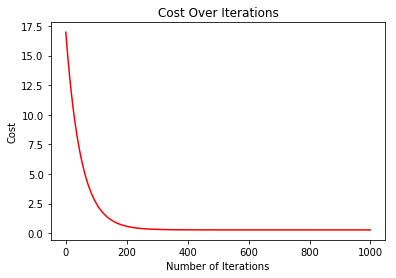

In [154]:
linear_model = LinearRegression(X = Xtrain, y = ytrain, learning_rate = .01, iterations = 1000, weight = 0)
linear_model.normalizeData()
linear_model.fit()
linear_model.plotCost()

The code above creates a linear model with a learning rate of .01 and 1000 iterations. The cost function is plotted above, which shows that this model began to converge around 200 iterastions and flattened out around 400. As stated above, however, I will be tuning this model utilizing cross-validation in order to find optimal parameters. I will be using a grid search for this.

In [169]:
params = {
            "learning_rate": [10e-5, 10e-4, 10e-3, 10e-2],
            "iterations": [10e1, 10e2, 10e3, 10e4 / 2]
        }

param_grid = list(itertools.product(params["learning_rate"], params["iterations"]))
cv_rmse = {}

for i in range(len(param_grid)):
    
    learning_rate, iterations = param_grid[i]
    iterations = int(iterations)
    predictions_score = []
    for j in range(5):
        
        skf = StratifiedKFold(n_splits = 5,
                     random_state = 490)

        Xtrain_cv, Xval, ytrain_cv, yval = train_test_split(Xtrain, ytrain, test_size = .30, random_state = 490)

        gs_mod = LinearRegression(X = Xtrain_cv, y = ytrain_cv, learning_rate = learning_rate, iterations = iterations, weight = 0)
        gs_mod.normalizeData()
        gs_mod.fit()
        
        predictions = gs_mod.predict(Xval, normalize = True)
        predictions_score.append(gs_mod.score(predictions, yval))
    
    print("On step {0} out of {1}".format(i+1, len(param_grid)))
    cv_rmse[i] = [param_grid[i], np.mean(predictions_score)]
        

On step 0 out of 16
On step 1 out of 16
On step 2 out of 16
On step 3 out of 16
On step 4 out of 16
On step 5 out of 16
On step 6 out of 16
On step 7 out of 16
On step 8 out of 16
On step 9 out of 16
On step 10 out of 16
On step 11 out of 16
On step 12 out of 16
On step 13 out of 16
On step 14 out of 16
On step 15 out of 16


In [173]:
cv_rmse

{0: [(0.0001, 100.0), 5.857431000472396],
 1: [(0.0001, 1000.0), 5.363594765477082],
 2: [(0.0001, 10000.0), 2.3087975657910795],
 3: [(0.0001, 50000.0), 0.7435432961665229],
 4: [(0.001, 100.0), 5.363356211609026],
 5: [(0.001, 1000.0), 2.307886418697267],
 6: [(0.001, 10000.0), 0.7395874611828963],
 7: [(0.001, 50000.0), 0.7402652046800035],
 8: [(0.01, 100.0), 2.2987396804068463],
 9: [(0.01, 1000.0), 0.7395869013262393],
 10: [(0.01, 10000.0), 0.742420320683704],
 11: [(0.01, 50000.0), 0.7450673195725356],
 12: [(0.1, 100.0), 0.7395825800690622],
 13: [(0.1, 1000.0), 0.7424230276920097],
 14: [(0.1, 10000.0), 0.7450716410720875],
 15: [(0.1, 50000.0), 0.7450716422375729]}

Looking at the output above, it looks like a jumbled mess. But each key in the dictionary has associated parameters (learning rate and number of iterations), and the cross-validated RMSE for those parameters. I want to go ahead and find the parameters associated with the minimum CV RMSE.

In [202]:
min_rmse = list(cv_rmse.items())[1][1][1]
best_params = list(cv_rmse.items())[1][1][0]
for cv_items in cv_rmse.items():
    if cv_items[1][1] < min_rmse:
        min_rmse = cv_items[1][1]
        best_params = cv_items[1][0]
print("Mininum CV RMSE: {0}\nBest Parameters: {1}".format(min_rmse, best_params))

Mininum CV RMSE: 0.7395825800690622
Best Parameters: (0.1, 100.0)


So our best parameters for this multivariate linear regression is a learning rate of .10, and 100 iterations.

Overall, we have found the best model utilizing multivariate linear regression. I will now be moving onto Ridge Regression.

<h2>Ridge Regression</h2>
I will be creating the first model using some base parameters of a learning rate of .01, 1000 iterations, and a weight of $ln(10)$.

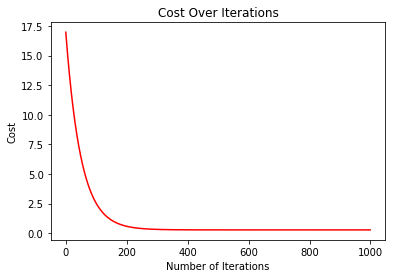

In [203]:
ridge_model = LinearRegression(X = Xtrain, y = ytrain, learning_rate = .01, iterations = 1000, weight = np.log(10))
ridge_model.normalizeData()
ridge_model.fit()
ridge_model.plotCost()

The code above creates a Ridge model with a learning rate of .01, 1000 iterations, and a weight of $ln(10)$. The cost function is plotted above, which shows that this model began to converge around 200 iterastions and flattened out around 400. As stated above, however, I will be tuning this model utilizing cross-validation in order to find optimal parameters. I will be using a grid search for this.

In [231]:
params = {
            "learning_rate": [.01, .1],
            "iterations": [100, 1000, 5000],
            "weight": np.log(np.linspace(10e-3, 10**10, num = 5))
        }

param_grid = list(itertools.product(params["learning_rate"], params["iterations"], params["weight"]))
cv_rmse_ridge = {}

for i in range(len(param_grid)):
    
    learning_rate, iterations, weight = param_grid[i]
    iterations = int(iterations)
    predictions_score = []
    for j in range(5):
        
        skf = StratifiedKFold(n_splits = 5,
                     random_state = 490)

        Xtrain_cv, Xval, ytrain_cv, yval = train_test_split(Xtrain, ytrain, test_size = .30, random_state = 490)

        gs_mod = LinearRegression(X = Xtrain_cv, y = ytrain_cv, learning_rate = learning_rate, iterations = iterations, weight = weight)
        gs_mod.normalizeData()
        gs_mod.fit()
        
        predictions = gs_mod.predict(Xval, normalize = True)
        predictions_score.append(gs_mod.score(predictions, yval))
    if i % 10 == 0:
        print("On step {0} out of {1}".format(i+1, len(param_grid)))
    cv_rmse_ridge[i] = [param_grid[i], np.mean(predictions_score)]

On step 1 out of 30
On step 11 out of 30
On step 21 out of 30


In [232]:
cv_rmse_ridge

{0: [(0.01, 100, -4.605170185988091), 2.2987320992550297],
 1: [(0.01, 100, 21.639556568823565), 2.298775342610635],
 2: [(0.01, 100, 22.332703749381512), 2.2987764859674495],
 3: [(0.01, 100, 22.738168857489008), 2.298777154818125],
 4: [(0.01, 100, 23.025850929940457), 2.2987776293885718],
 5: [(0.01, 1000, -4.605170185988091), 0.7395786951525869],
 6: [(0.01, 1000, 21.639556568823565), 0.7396347054173761],
 7: [(0.01, 1000, 22.332703749381512), 0.7396364815792185],
 8: [(0.01, 1000, 22.738168857489008), 0.7396375274481833],
 9: [(0.01, 1000, 23.025850929940457), 0.739638272579785],
 10: [(0.01, 5000, -4.605170185988091), 0.7403540662493386],
 11: [(0.01, 5000, 21.639556568823565), 0.7399596977314868],
 12: [(0.01, 5000, 22.332703749381512), 0.7399524884105306],
 13: [(0.01, 5000, 22.738168857489008), 0.7399483359951139],
 14: [(0.01, 5000, 23.025850929940457), 0.7399454185704311],
 15: [(0.1, 100, -4.605170185988091), 0.7395746665447346],
 16: [(0.1, 100, 21.639556568823565), 0.7396

Looking at the output above, it once again looks like a jumbled mess. But each key in the dictionary has associated parameters (learning rate and number of iterations), and the cross-validated RMSE for those parameters. I want to go ahead and find the parameters associated with the minimum CV RMSE.

In [236]:
min_rmse_ridge = list(cv_rmse_ridge.items())[1][1][1]
best_params_ridge = list(cv_rmse_ridge.items())[1][1][0]
for cv_items in cv_rmse_ridge.items():
    if cv_items[1][1] < min_rmse_ridge:
        min_rmse_ridge = cv_items[1][1]
        best_params_ridge = cv_items[1][0]
print("Mininum CV RMSE: {0}\nBest Parameters: {1}".format(min_rmse_ridge, best_params_ridge))

Mininum CV RMSE: 0.7395746665447346
Best Parameters: (0.1, 100, -4.605170185988091)


So our best parameters for this multivariate linear regression is a learning rate of .10, 100 iterations, and a weight of $e^{-4.605} (\approx .01).$ This weight is near zero, meaning there is not much coefficient shrinkage happening.

With the Ridge regression model built, I will now compare the minimum CV RMSE's and choose the best model that I will be evaluating on the held out test data.

In [247]:
rmses_df = pd.DataFrame(data = np.column_stack((min_rmse, min_rmse_ridge)),
                       columns = ["Min RMSE MVR", "Min RMSE Ridge"])
rmses_df.style.hide_index()

Min RMSE MVR,Min RMSE Ridge
0.739583,0.739575


Looking at the table above, the CV RMSE for our best Ridge regression model slightly outperforms the multivariate model. The Ridge model will be selected as the best model by this criterion, and used for test data evaluation.

I will now create the best model, and plot the cost function to take a look at the descent and then evaluate.

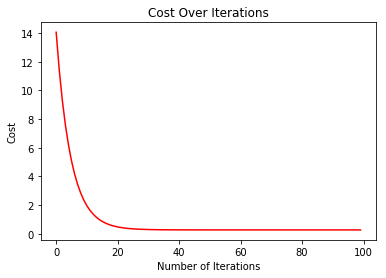

In [248]:
best_model = LinearRegression(X = Xtrain, y = ytrain, learning_rate = .1, iterations= 100, weight = np.log(10e-3))
best_model.normalizeData()
best_model.fit()
best_model.plotCost()

The best model chosen converges around 30ish iterations, which makes this model accurate as well as efficient.

<h2>Model Evaluation</h2>

With the best model built, it is time to evaluate it on the held out test data.

In [249]:
test_predictions = best_model.predict(data = Xtest, normalize = True)
test_rmse = best_model.score(test_predictions, ytest)
print("Test RMSE: {0}".format(test_rmse))

Test RMSE: 0.7310123842482915


Looking at the test RMSE above, it performs on par (even slightly better), than the cross-validated RMSE we obtained before. This is great, as it tells me that this model is not overfitting to the training data.

Overall, this model is useful for predicting on unseen data.

<h2>Conclusion</h2>

Overall in this project I have analyzed the wine quality dataset and set it up for predictions. I then built a Python class that performs multivariate linear regression as well as Ridge regression utilizing gradient descent. I have shown, but not mentioned, that a larger learning rate and less iterations performs the best on linear regression models as it is quite efficient and easy to find the minimum of the cost function. I have then shown that this model performs well on unseen test data, and is useful for predictions outside the training data.